# 7. Domain specific applications

In addition to the default features (delayed, array, dataframe, bag) offered by Dask, there are additional domain-specific modules. We are looking at two of them here: machine learning and image processing.

## 7.1 dask_ml

Just like dask-array is a port of Numpy to Dask, dask_ml is a port from sckit-learn to Dask. Scikit-learn is currently probably the most popular machine-learning package in Python. Dask offers a subset of function available in scikit-learn using the same syntax. Let's see an example. The calculation is **only for the purpose of illustration** and is not realistic.

We look again at the taxi dataset:

In [1]:
from dask.distributed import Client

client = Client()#"tcp://127.0.0.1:49550")
client

Client Scheduler: tcp://127.0.0.1:65191 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [ ]:
import dask.dataframe as dd

In [3]:
taxi = dd.read_csv('../Data/NYC_Taxi/yellow_tripdata_2020-04.csv',
                   dtype={'RatecodeID': 'float64',
                          'VendorID': 'float64',
                          'passenger_count': 'float64',
                          'payment_type': 'float64'})

We are working here on a trivial question and checking whether there's a relation between the trip length and the amount of the fare. We only keep those two variables:

In [4]:
taxi

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
npartitions=1,,,,,,,,,,,,,,,,,,
,float64,object,object,float64,float64,float64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
taxi = taxi[['trip_distance', 'tip_amount']]

We only keep "reasonable data" and exclude the no tip cases (a majority of those represent absence of data from people paying in liquid).

In [6]:
taxi = taxi[(taxi.trip_distance<1000) & (taxi.tip_amount>0)][['trip_distance', 'tip_amount']]

In [7]:
#taxi = taxi.dropna()

Then we can easily split out dataset into train and test sets:

In [8]:
train, test = taxi.random_split([0.8, 0.2])

We pick a linear regression model from dask_ml:

In [9]:
from dask_ml.linear_model import LinearRegression

We create a linear fit object as we would do it in scikit-learn:

In [10]:
linfit = LinearRegression(fit_intercept=False)

And we call the ```fit()``` method like for any other scikit-ml method:

In [11]:
linfit_model = linfit.fit(train[['trip_distance']].values,train[['tip_amount']].values)

We can then predict values for our test set:

In [12]:
pred = linfit_model.predict(test[['trip_distance']].values)

And we see that the model takes in  dask object and also generates a dask object. Hence we can do prediction for large datasets! Finally we can look at our fit:

(0.0, 200.0)

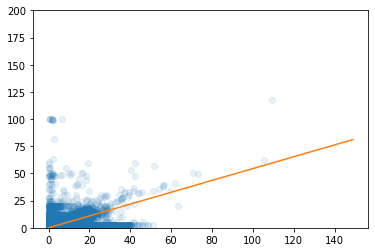

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
plt.plot(train[['trip_distance']].values.compute(), train[['tip_amount']].values.compute(),'o',alpha = 0.1)
plt.plot(np.arange(0,150), linfit_model.coef_[0]*np.arange(0,150))
ax.set_ylim([0,200])

## 7.2 dask-image

We have seen before that we could wrap an image importer and other image processing functions into ```delay()``` calls. However Dask offers a built-in set of functions to deal with images. We are going to illustrate this through examples.

In [5]:
from dask_image import imread, ndfilters
import dask
import matplotlib.pyplot as plt

First, dask-image can simplify the work with large series of images. As for example we could previously load series of dataframes automatically, we can do the same here with images. We use the same dataset as before and specify a name pattern of files to laod with the dask-image ```imread``` function:

In [3]:
images = imread.imread('../Data/BBBC006_v1_images_z_16/*_w1*.tif')

In [4]:
images

,Array,Chunk
Bytes,104.23 MB,723.84 kB
Shape,"(144, 520, 696)","(1, 520, 696)"
Count,432 Tasks,144 Chunks
Type,uint16,numpy.ndarray


As we can see, this automatically creates a large 3D array where images have been stacked together. Now we filter each image using a gaussian filter implemented in dask-image:

In [5]:
im_filtered = ndfilters.gaussian_filter(images, sigma=(0,5,5))

We recover both the original and filtere image for comparison. Note that this is not something that one would typically do as it loads all data into RAM:

In [6]:
result = dask.compute(images, im_filtered)

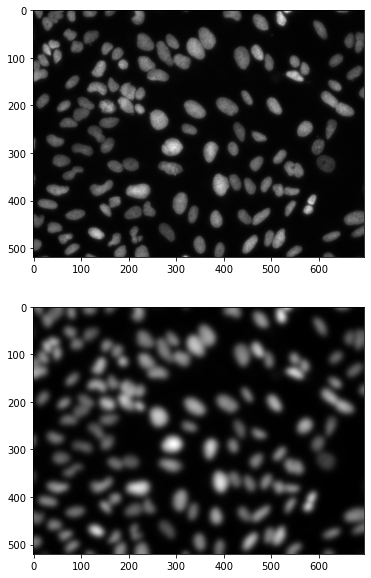

In [7]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].imshow(result[0][100,:,:],cmap = 'gray')
ax[1].imshow(result[1][100,:,:],cmap = 'gray')

Above, 3D dask array is organized in such a way that an image is an individual chunk. This might not always be the case. For example, the stack might actually represent 3D data. Also in that case, the filtering functions of dask-image are of great help, as they know how to operate "across" chunks. We illustrate that with a single 2D image:

In [3]:
from skimage import io, filters, morphology
from skimage.color import rgb2gray

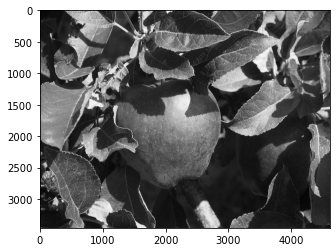

In [6]:
image = rgb2gray(io.imread('images/apfel.jpg'))
plt.imshow(image, cmap = 'gray')

In [8]:
image.shape

(3456, 4608)

We have here a regular Numpy array. For the purpose of illustration, we turn it into a chunked dask array:

In [9]:
im_da = dask.array.from_array(image, chunks=2000)

In [10]:
im_da

dask.array<array, shape=(3456, 4608), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

Now let's filter this image with a median filter, first in a classic approach:

In [16]:
%%time
filtered_classic = filters.median(image, selem=morphology.square(20))

CPU times: user 52.9 s, sys: 871 ms, total: 53.8 s
Wall time: 55.6 s


Now using dask:

In [22]:
filtered_dask = ndfilters.median_filter(im_da, size=20)

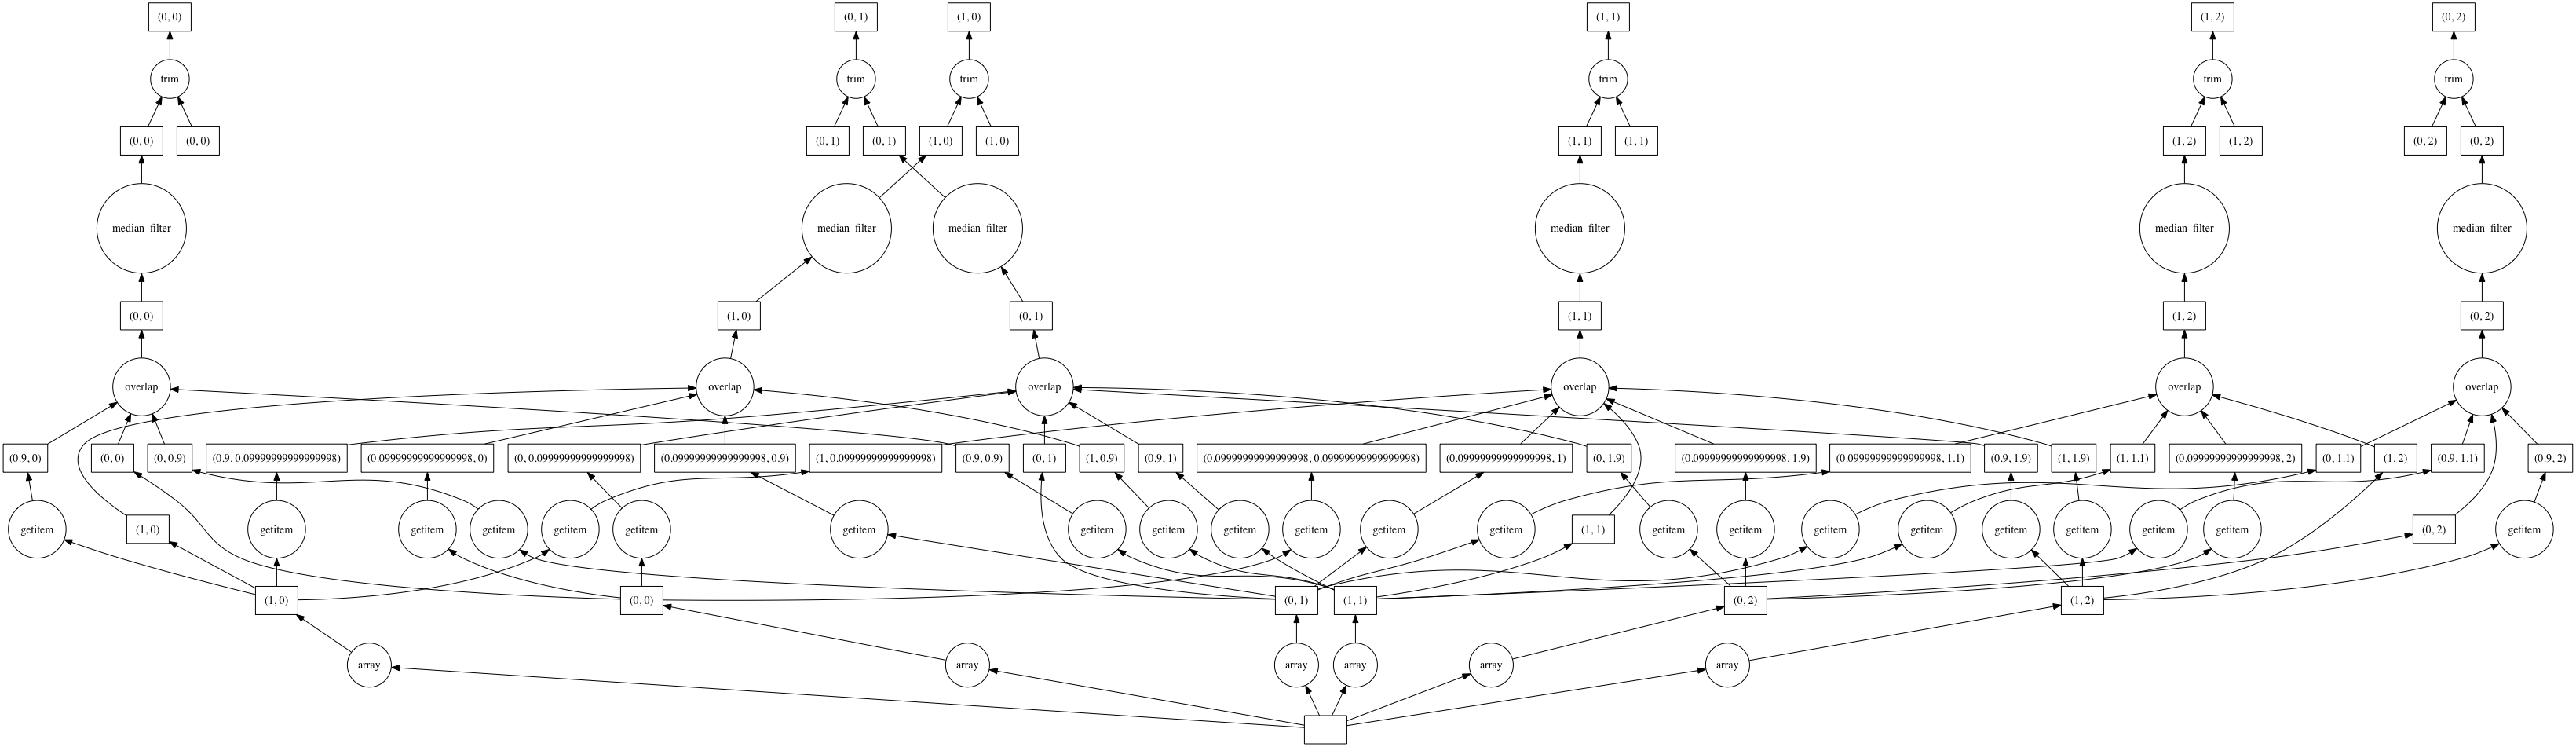

In [23]:
filtered_dask.visualize()

We see a relatively complex task graph. The reason for this is that at the juncture of chunks, the filter needs information from multiple chunks. While one can easily chop an array in pieces to apply a function in parallel, this tedious work for borders is done here automatically!

In [24]:
%%time
filtered_dask = ndfilters.median_filter(im_da, size=20)
filtered_dask = filtered_dask.compute()

CPU times: user 1.47 s, sys: 479 ms, total: 1.95 s
Wall time: 29.6 s


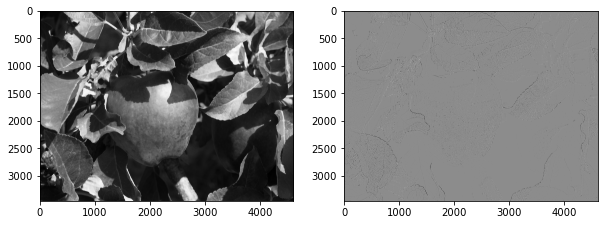

In [30]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(filtered_dask, cmap = 'gray')
ax[1].imshow(filtered_dask-image, cmap = 'gray')

We see that even here, with an image of modest size, the parallel computing offered by "chunk-calculation" brings an important benefit!